# EDA

**We were working with a database on Snowflake, which won't be available at the time you read this notebook. However, I left the SQL queries for you to have a general understanding of how I generated the plots.**

In [ ]:
!pip install snowflake-connector-python
!pip install pyarrow==8.0.0
%pip install geopandas
%pip install Fiona
%pip install folium matplotlib mapclassify
!pip install snowflake-connector-python


In [ ]:
import pandas as pd 
import geopandas as gpd
import matplotlib.pyplot as plt
import folium
import snowflake.connector
import seaborn as sns
sns.set(rc={"figure.figsize":(20, 10)}) 

ctx = snowflake.connector.connect(
                user="...",
                password="...",
                account="rz80876",
                region="eu-central-1",
                warehouse="PUBLIC",
                database="RAIN",
                schema="PUBLIC"
                )

## Average Absolute Error and Relative Average Absolute Error

**I compute the date range and mean absolute error between target and rain gauge measurement. I considered the absolute value of the difference because otherwise positive and negative errors may cancel each other out.**

In [ ]:
### SECOND TARGET date range
sql_query= """SELECT MAX(pgm.MEASUREMENT_DATE) AS max_date_second_target, MIN(pgm.MEASUREMENT_DATE) AS min_date_second_target, AVG(ABS(MEAN_TARGET - PRCP)) AS ABS_DIFFERENCE_second_target
FROM catchment_features cf
INNER JOIN precipitation_gauge_features pgf ON cf.HYBAS_ID = pgf.HYBAS_ID 
INNER JOIN precipitation_gauge_measurements pgm ON pgf.STATION = pgm.STATION 
INNER JOIN SECOND_TARGET t ON t.ZONE = pgf.HYBAS_ID AND YEAR(t.DATE_TARGET) = YEAR(pgm.MEASUREMENT_DATE) AND MONTH(t.DATE_TARGET) = MONTH(pgm.MEASUREMENT_DATE) AND DAY(t.DATE_TARGET) = DAY(pgm.MEASUREMENT_DATE);"""


cursor = ctx.cursor()
cursor.execute(sql_query)
data = cursor.fetchall()
num_fields = len(cursor.description)
columns = [i[0].lower() for i in cursor.description]
df = pd.DataFrame(data, columns=columns)
cursor.close()

True

In [ ]:
df.head()

,max_date_second_target,min_date_second_target,abs_difference_second_target
0,2021-06-30,2010-01-01,3.024914


**If we consider only the rainy days (target > 10), then the average difference is much higher**

In [ ]:
###  SECOND TARGET date range
sql_query= """SELECT AVG(ABS(MEAN_TARGET - PRCP)) AS ABS_DIFFERENCE_second_target_if_raining
FROM catchment_features cf
INNER JOIN precipitation_gauge_features pgf ON cf.HYBAS_ID = pgf.HYBAS_ID 
INNER JOIN precipitation_gauge_measurements pgm ON pgf.STATION = pgm.STATION 
INNER JOIN SECOND_TARGET t ON t.ZONE = pgf.HYBAS_ID AND YEAR(t.DATE_TARGET) = YEAR(pgm.MEASUREMENT_DATE) AND MONTH(t.DATE_TARGET) = MONTH(pgm.MEASUREMENT_DATE) AND DAY(t.DATE_TARGET) = DAY(pgm.MEASUREMENT_DATE)
WHERE t.DATE_TARGET < '2021-06-30' AND t.DATE_TARGET > '2015-01-01' AND t.MEAN_TARGET > 10;"""
 

cursor = ctx.cursor()
cursor.execute(sql_query)
data = cursor.fetchall()
num_fields = len(cursor.description)
columns = [i[0].lower() for i in cursor.description]
df = pd.DataFrame(data, columns=columns)
cursor.close()

True

In [ ]:
df.head()

,abs_difference_second_target_if_raining
0,15.728619


## Error vs Features of the dataset

**here I start plotting the error (absolute and relative) vs different features of the dataset to see if they could be useful features for a ML algorithm**

### average absolute error vs month of the year

In [ ]:
sql_query= """SELECT AVG(ABS(MEAN_TARGET - PRCP)) AS ABS_DIFFERENCE, MONTH(t.DATE_TARGET) AS MONTH  FROM catchment_features cf
INNER JOIN precipitation_gauge_features pgf ON cf.HYBAS_ID = pgf.HYBAS_ID 
INNER JOIN precipitation_gauge_measurements pgm ON pgf.STATION = pgm.STATION 
INNER JOIN SECOND_TARGET t ON t.ZONE = pgf.HYBAS_ID AND YEAR(t.DATE_TARGET) = YEAR(pgm.MEASUREMENT_DATE) AND MONTH(t.DATE_TARGET) = MONTH(pgm.MEASUREMENT_DATE) AND DAY(t.DATE_TARGET) = DAY(pgm.MEASUREMENT_DATE)
WHERE t.mean_target > 5
GROUP BY MONTH(t.DATE_TARGET);"""


cursor = ctx.cursor()
cursor.execute(sql_query)
data = cursor.fetchall()
num_fields = len(cursor.description)
columns = [i[0].lower() for i in cursor.description]
df_month = pd.DataFrame(data, columns=columns)
cursor.close()


True

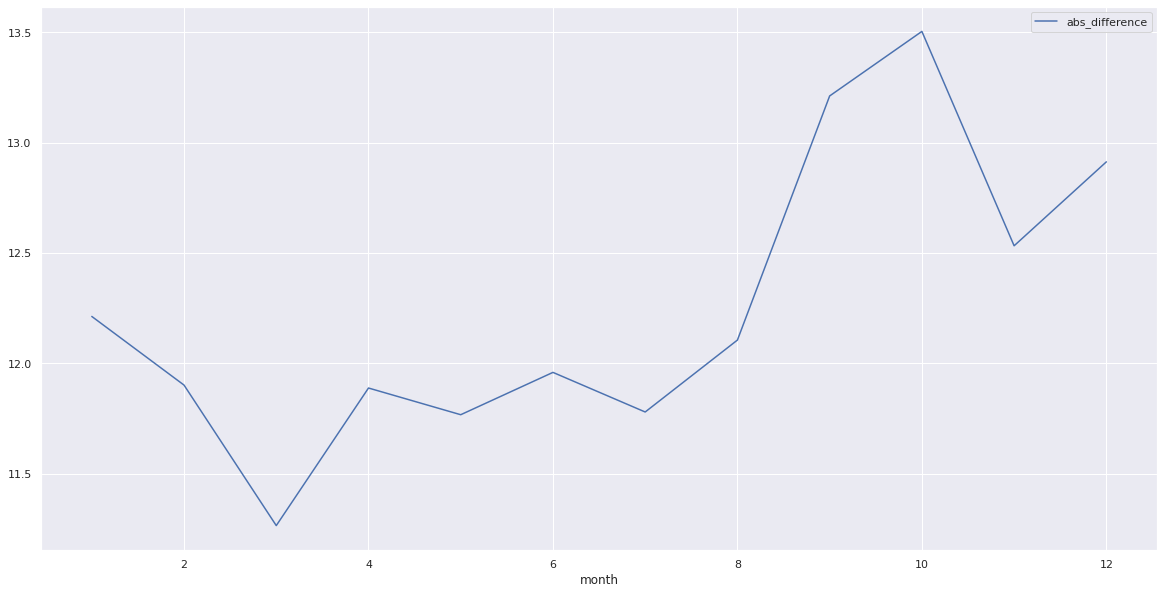

In [ ]:
df_month = df_month.sort_values("month")
df_month.plot.line(x="month", y="abs_difference", figsize=(20, 10))

**a spike in the error in the autumn months may be given by the higher amount of precipitation in that time of the year, so a "relative error" has been computed**

### average relative error vs month of the year

In [ ]:

# mean RELATIVE difference between radar meas and rain gauge meas if raining (t.mean_target > 5)
sql_query= """SELECT AVG(ABS(MEAN_TARGET - PRCP) / MEAN_TARGET) AS RELATIVE_DIFFERENCE, MONTH(t.DATE_TARGET) AS MONTH  FROM catchment_features cf
INNER JOIN precipitation_gauge_features pgf ON cf.HYBAS_ID = pgf.HYBAS_ID 
INNER JOIN precipitation_gauge_measurements pgm ON pgf.STATION = pgm.STATION 
INNER JOIN SECOND_TARGET t ON t.ZONE = pgf.HYBAS_ID AND YEAR(t.DATE_TARGET) = YEAR(pgm.MEASUREMENT_DATE) AND MONTH(t.DATE_TARGET) = MONTH(pgm.MEASUREMENT_DATE) AND DAY(t.DATE_TARGET) = DAY(pgm.MEASUREMENT_DATE)
WHERE t.mean_target > 5
GROUP BY MONTH(t.DATE_TARGET);"""


cursor = ctx.cursor()
cursor.execute(sql_query)
data = cursor.fetchall()
num_fields = len(cursor.description)
columns = [i[0].lower() for i in cursor.description]
df_month_corrected = pd.DataFrame(data, columns=columns)
cursor.close()

True

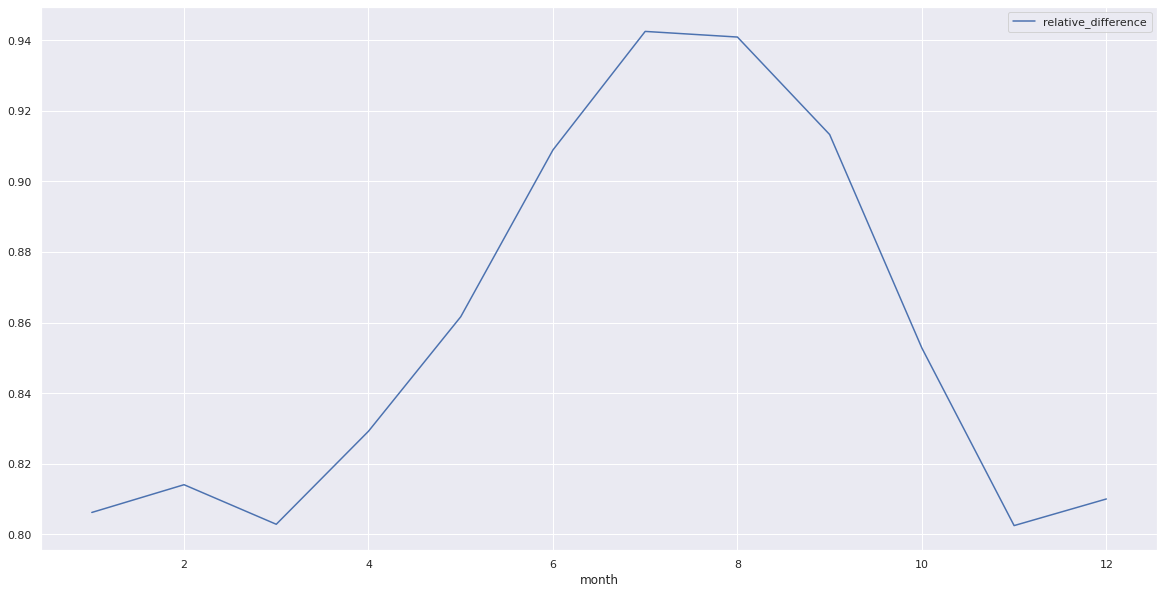

In [ ]:
df_month_corrected = df_month_corrected.sort_values("month")
df_month_corrected.plot.line(x="month", y="relative_difference", figsize=(20, 10))

**It seems like months around July/August have a higher difference between target and rain gauge measurement**

### average absolute error vs altitude of the catchment 

In [ ]:
sql_query= """SELECT AVG(ABS(MEAN_TARGET - PRCP)) AS ABS_DIFFERENCE, cf.ALTITUDE_MEAN , COUNT(*) As count
FROM catchment_features cf
INNER JOIN precipitation_gauge_features pgf ON cf.HYBAS_ID = pgf.HYBAS_ID 
INNER JOIN precipitation_gauge_measurements pgm ON pgf.STATION = pgm.STATION 
INNER JOIN SECOND_TARGET t ON t.ZONE = pgf.HYBAS_ID AND YEAR(t.DATE_TARGET) = YEAR(pgm.MEASUREMENT_DATE) AND MONTH(t.DATE_TARGET) = MONTH(pgm.MEASUREMENT_DATE) AND DAY(t.DATE_TARGET) = DAY(pgm.MEASUREMENT_DATE)
WHERE t.mean_target > 5
GROUP BY cf.ALTITUDE_MEAN;"""

cursor = ctx.cursor()
cursor.execute(sql_query)
data = cursor.fetchall()
num_fields = len(cursor.description)
columns = [i[0].lower() for i in cursor.description]
df_altitude = pd.DataFrame(data, columns=columns)
cursor.close()



True

In [ ]:
df_altitude.head()

,abs_difference,altitude_mean,count
0,14.925847,302.282715,308
1,10.292023,270.896252,8773
2,10.976249,222.541502,12768
3,12.088504,279.605467,21920
4,11.637274,294.811843,14751


In [ ]:
df_altitude = df_altitude.dropna(axis=0)

**I plot the size of each point proportional to the value "count" (the number of catchments having the same altitude. The bigger the number, the bigger should be the effect on the regression line**

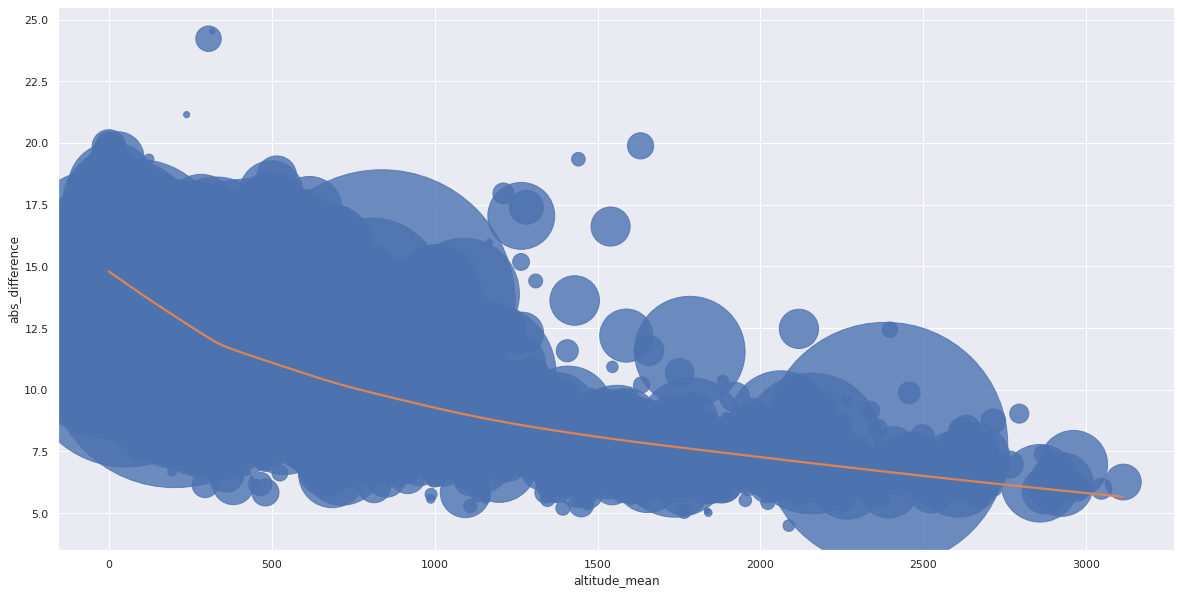

In [ ]:
sns.regplot(x='altitude_mean', y='abs_difference', data=df_altitude, scatter_kws={'s': df_altitude['count']}, lowess = True, line_kws={"color": "C1"})


### average relative absolute error vs altitude of the catchment 

In [ ]:
sql_query= """SELECT AVG(ABS(MEAN_TARGET - PRCP) / MEAN_TARGET) AS RELATIVE_DIFFERENCE, cf.ALTITUDE_MEAN, COUNT(*) As count
FROM catchment_features cf
INNER JOIN precipitation_gauge_features pgf ON cf.HYBAS_ID = pgf.HYBAS_ID 
INNER JOIN precipitation_gauge_measurements pgm ON pgf.STATION = pgm.STATION 
INNER JOIN SECOND_TARGET t ON t.ZONE = pgf.HYBAS_ID AND YEAR(t.DATE_TARGET) = YEAR(pgm.MEASUREMENT_DATE) AND MONTH(t.DATE_TARGET) = MONTH(pgm.MEASUREMENT_DATE) AND DAY(t.DATE_TARGET) = DAY(pgm.MEASUREMENT_DATE)
WHERE t.mean_target > 5
GROUP BY cf.ALTITUDE_MEAN;"""

cursor = ctx.cursor()
cursor.execute(sql_query)
data = cursor.fetchall()
num_fields = len(cursor.description)
columns = [i[0].lower() for i in cursor.description]
df_altitude_relative = pd.DataFrame(data, columns=columns)
cursor.close()
df_altitude_relative = df_altitude_relative.dropna(axis=0)

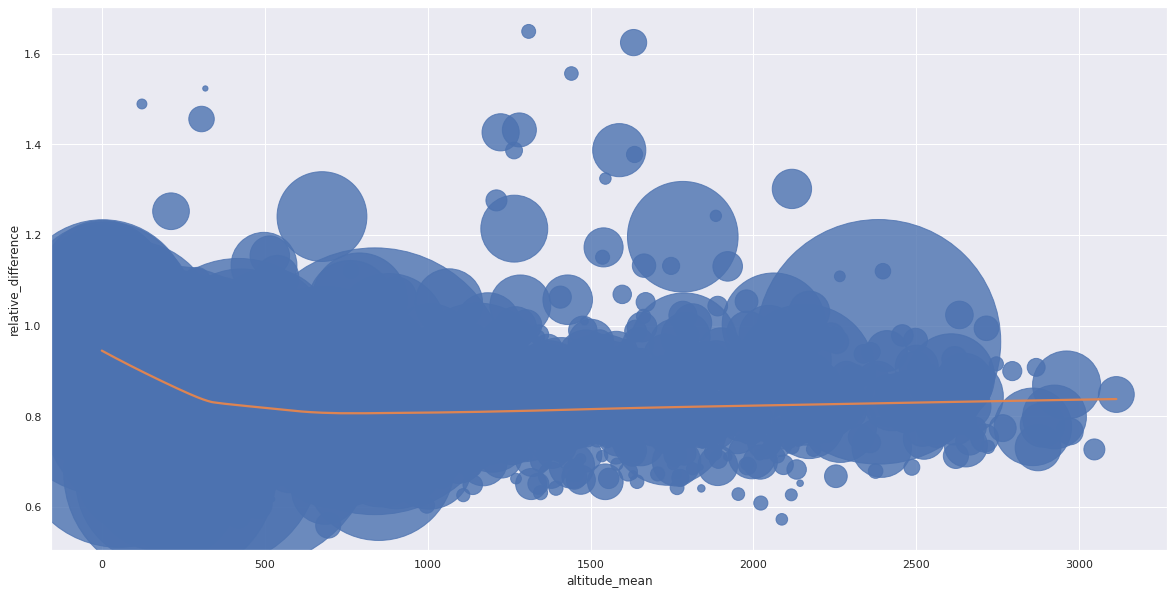

In [ ]:
sns.regplot(x='altitude_mean', y='relative_difference', data=df_altitude_relative, scatter_kws={'s': df_altitude_relative['count']}, lowess = True, line_kws={"color": "C1"})

**it seems that catchments that are higher than 300m have more accurate rain gauges measurements**

**as requested, I also print the relatitive difference without the absolute value, however I am not sure what it can tell, since positive errors cancel negative ones.**

### average relative error (no absolute value) vs altitude of the catchment 

In [ ]:
sql_query= """SELECT AVG((MEAN_TARGET - PRCP) / MEAN_TARGET) AS RELATIVE_DIFFERENCE, cf.ALTITUDE_MEAN, COUNT(*) As count
FROM catchment_features cf
INNER JOIN precipitation_gauge_features pgf ON cf.HYBAS_ID = pgf.HYBAS_ID 
INNER JOIN precipitation_gauge_measurements pgm ON pgf.STATION = pgm.STATION 
INNER JOIN SECOND_TARGET t ON t.ZONE = pgf.HYBAS_ID AND YEAR(t.DATE_TARGET) = YEAR(pgm.MEASUREMENT_DATE) AND MONTH(t.DATE_TARGET) = MONTH(pgm.MEASUREMENT_DATE) AND DAY(t.DATE_TARGET) = DAY(pgm.MEASUREMENT_DATE)
WHERE t.mean_target > 5
GROUP BY cf.ALTITUDE_MEAN;"""

cursor = ctx.cursor()
cursor.execute(sql_query)
data = cursor.fetchall()
num_fields = len(cursor.description)
columns = [i[0].lower() for i in cursor.description]
df_altitude_relative = pd.DataFrame(data, columns=columns)
cursor.close()
df_altitude_relative = df_altitude_relative.dropna(axis=0)

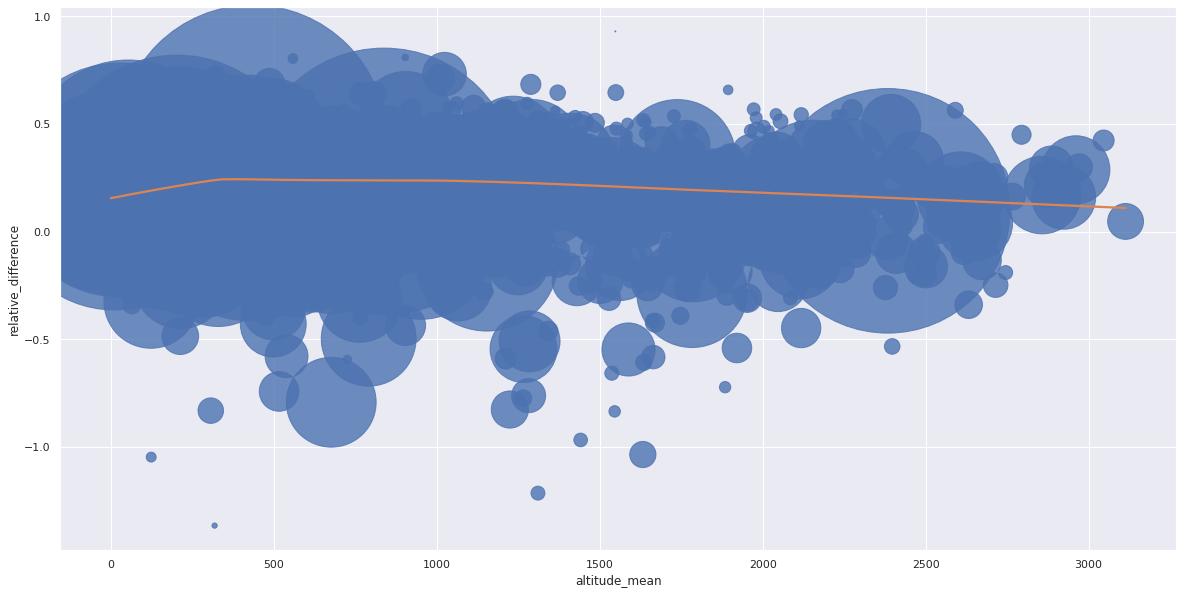

In [ ]:
sns.regplot(x='altitude_mean', y='relative_difference', data=df_altitude_relative, scatter_kws={'s': df_altitude_relative['count']}, lowess = True, line_kws={"color": "C1"})

### average absolute difference vs catchment slope

In [ ]:
sql_query= """SELECT cf.SLOPE_MEAN, AVG(ABS(MEAN_TARGET - PRCP)) AS ABS_DIFFERENCE, COUNT(*) As count
FROM catchment_features cf 
INNER JOIN precipitation_gauge_features pgf ON cf.HYBAS_ID = pgf.HYBAS_ID 
INNER JOIN precipitation_gauge_measurements pgm ON pgf.STATION = pgm.STATION 
INNER JOIN SECOND_TARGET t ON t.ZONE = pgf.HYBAS_ID AND YEAR(t.DATE_TARGET) = YEAR(pgm.MEASUREMENT_DATE) AND MONTH(t.DATE_TARGET) = MONTH(pgm.MEASUREMENT_DATE) AND DAY(t.DATE_TARGET) = DAY(pgm.MEASUREMENT_DATE)
WHERE t.mean_target > 5
GROUP BY cf.SLOPE_MEAN;"""

cursor = ctx.cursor()
cursor.execute(sql_query)
data = cursor.fetchall()
num_fields = len(cursor.description)
columns = [i[0].lower() for i in cursor.description]
df_solpe_mean = pd.DataFrame(data, columns=columns)
cursor.close()
df_solpe_mean = df_solpe_mean.dropna(axis=0)

True

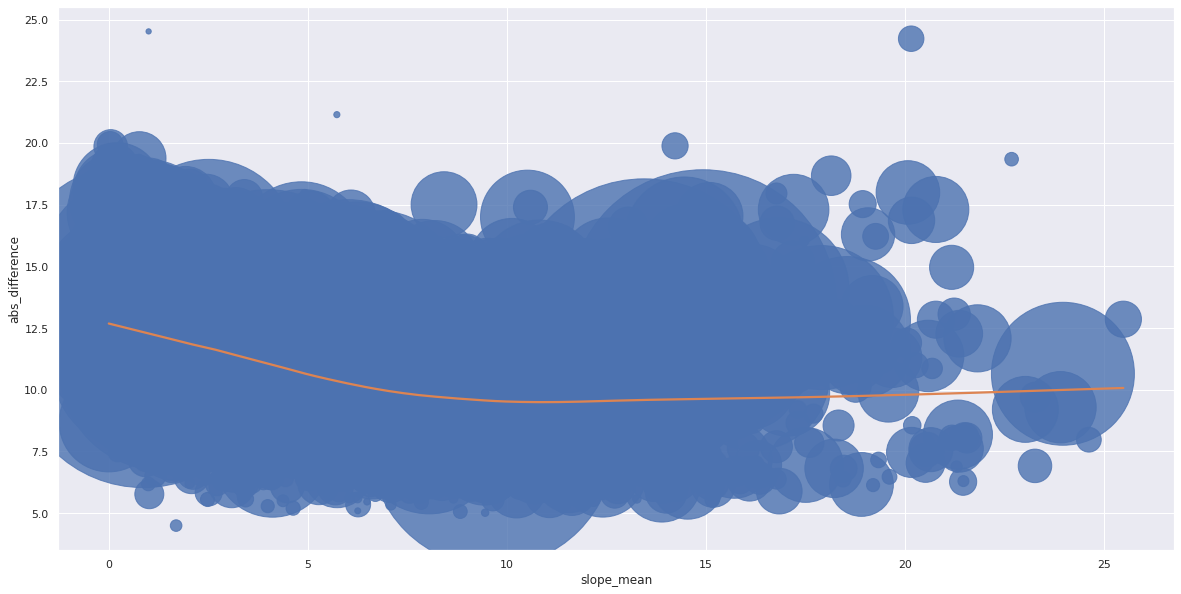

In [ ]:
sns.regplot(x='slope_mean', y='abs_difference', data=df_solpe_mean, scatter_kws={'s': df_solpe_mean['count']}, lowess = True, line_kws={"color": "C1"})

**it seems like that catchments with an higher slope have more accurate rain gauges, however, it is probably given by the fact that higher slope catchments receive less rain**

### average relative absolute difference vs catchment slope

In [ ]:
sql_query= """SELECT cf.SLOPE_MEAN, AVG(ABS(MEAN_TARGET - PRCP) / MEAN_TARGET) AS RELATIVE_DIFFERENCE , COUNT(*) As count
FROM catchment_features cf
INNER JOIN precipitation_gauge_features pgf ON cf.HYBAS_ID = pgf.HYBAS_ID 
INNER JOIN precipitation_gauge_measurements pgm ON pgf.STATION = pgm.STATION 
INNER JOIN SECOND_TARGET t ON t.ZONE = pgf.HYBAS_ID AND YEAR(t.DATE_TARGET) = YEAR(pgm.MEASUREMENT_DATE) AND MONTH(t.DATE_TARGET) = MONTH(pgm.MEASUREMENT_DATE) AND DAY(t.DATE_TARGET) = DAY(pgm.MEASUREMENT_DATE)
WHERE t.mean_target > 5
GROUP BY cf.SLOPE_MEAN;"""

cursor = ctx.cursor()
cursor.execute(sql_query)
data = cursor.fetchall()
num_fields = len(cursor.description)
columns = [i[0].lower() for i in cursor.description]
df_solpe_mean_relative = pd.DataFrame(data, columns=columns)
cursor.close()
df_solpe_mean_relative = df_solpe_mean_relative.dropna(axis=0)

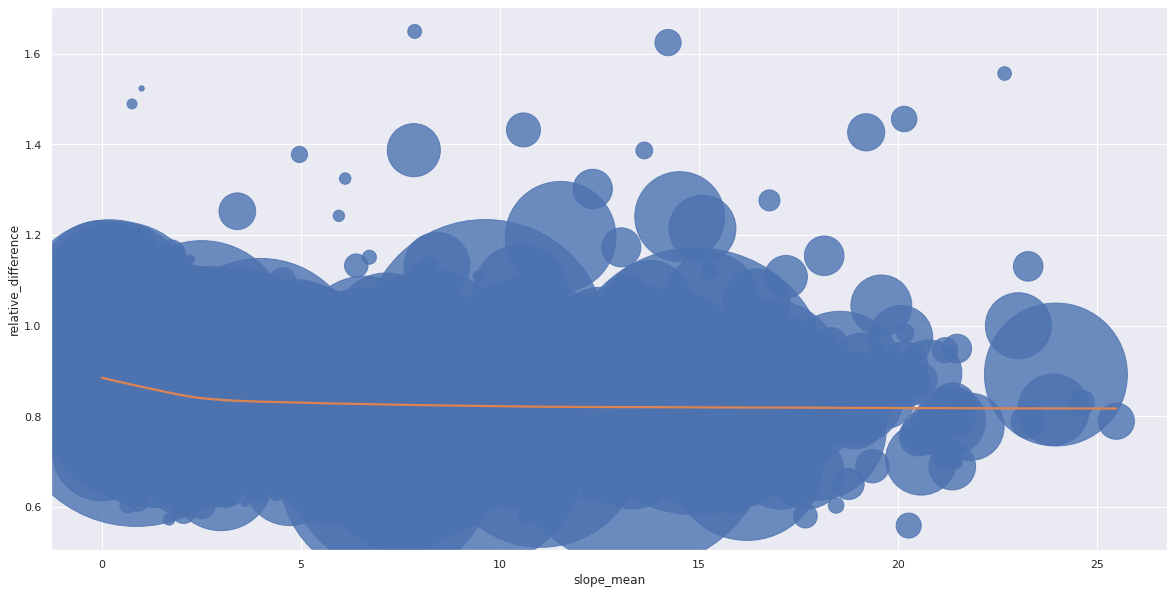

In [ ]:
sns.regplot(x='slope_mean', y='relative_difference', data=df_solpe_mean_relative, scatter_kws={'s': df_solpe_mean_relative['count']}, lowess = True, line_kws={"color": "C1"})

**the relative absolute differece doesn't change that much, so I suspect that the slope might not be a good feature for the model**




### absolute difference vs difference between rain gauge altitude and the mean altitude of the catchment

In [ ]:
sql_query= """SELECT (cf.ALTITUDE_MEAN - pgf.elevation) AS mean_altitude_gauge_elevation_diff, AVG(ABS(MEAN_TARGET - PRCP)) AS ABS_DIFFERENCE , COUNT(*) As count
FROM catchment_features cf
INNER JOIN precipitation_gauge_features pgf ON cf.HYBAS_ID = pgf.HYBAS_ID 
INNER JOIN precipitation_gauge_measurements pgm ON pgf.STATION = pgm.STATION 
INNER JOIN SECOND_TARGET t ON t.ZONE = pgf.HYBAS_ID AND YEAR(t.DATE_TARGET) = YEAR(pgm.MEASUREMENT_DATE) AND MONTH(t.DATE_TARGET) = MONTH(pgm.MEASUREMENT_DATE) AND DAY(t.DATE_TARGET) = DAY(pgm.MEASUREMENT_DATE)
WHERE t.mean_target > 5
GROUP BY (cf.ALTITUDE_MEAN - pgf.elevation);"""

cursor = ctx.cursor()
cursor.execute(sql_query)
data = cursor.fetchall()
num_fields = len(cursor.description)
columns = [i[0].lower() for i in cursor.description]
df_altitude_gauge_elev_diff = pd.DataFrame(data, columns=columns)
cursor.close()
df_altitude_gauge_elev_diff = df_altitude_gauge_elev_diff.dropna(axis=0)

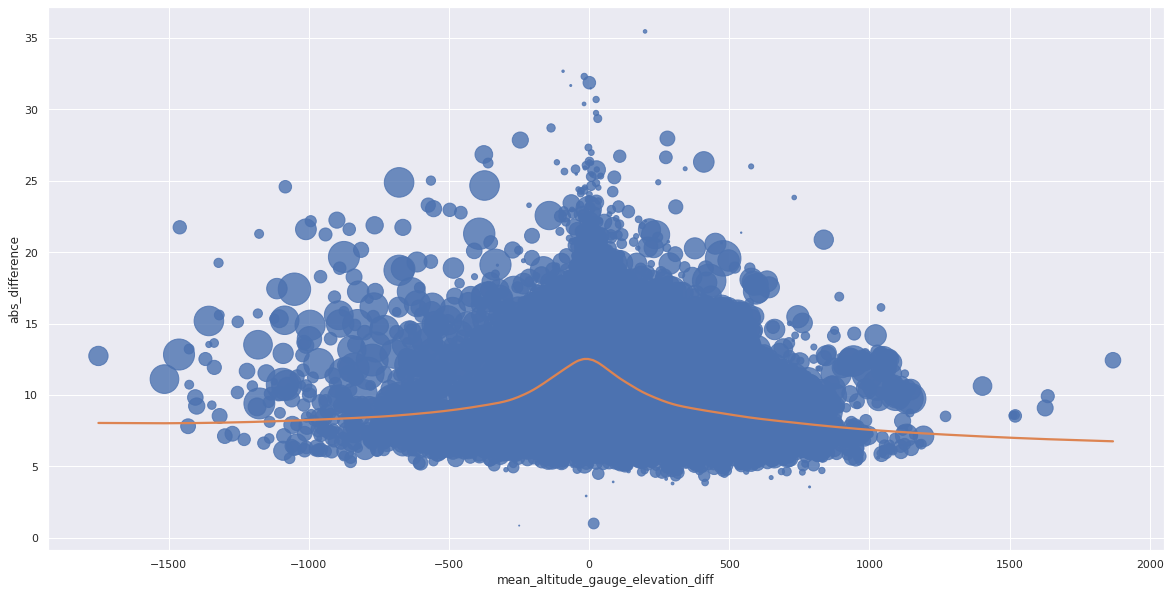

In [ ]:
sns.regplot(x='mean_altitude_gauge_elevation_diff', y='abs_difference', data=df_altitude_gauge_elev_diff, scatter_kws={'s': df_altitude_gauge_elev_diff['count']}, lowess = True, line_kws={"color": "C1"})


### relative absolute difference vs difference between rain gauge altitude and the mean altitude of the catchment

In [ ]:
sql_query= """SELECT (cf.ALTITUDE_MEAN - pgf.elevation) AS mean_altitude_gauge_elevation_diff, AVG(ABS(MEAN_TARGET - PRCP) / MEAN_TARGET) AS RELATIVE_DIFFERENCE , COUNT(*) As count
FROM catchment_features cf 
INNER JOIN precipitation_gauge_features pgf ON cf.HYBAS_ID = pgf.HYBAS_ID 
INNER JOIN precipitation_gauge_measurements pgm ON pgf.STATION = pgm.STATION 
INNER JOIN SECOND_TARGET t ON t.ZONE = pgf.HYBAS_ID AND YEAR(t.DATE_TARGET) = YEAR(pgm.MEASUREMENT_DATE) AND MONTH(t.DATE_TARGET) = MONTH(pgm.MEASUREMENT_DATE) AND DAY(t.DATE_TARGET) = DAY(pgm.MEASUREMENT_DATE)
WHERE t.mean_target > 5
GROUP BY (cf.ALTITUDE_MEAN - pgf.elevation);"""

cursor = ctx.cursor()
cursor.execute(sql_query)
data = cursor.fetchall()
num_fields = len(cursor.description)
columns = [i[0].lower() for i in cursor.description]
df_altitude_gauge_elev_diff_relative = pd.DataFrame(data, columns=columns)
cursor.close()
df_altitude_gauge_elev_diff_relative = df_altitude_gauge_elev_diff_relative.dropna(axis=0)

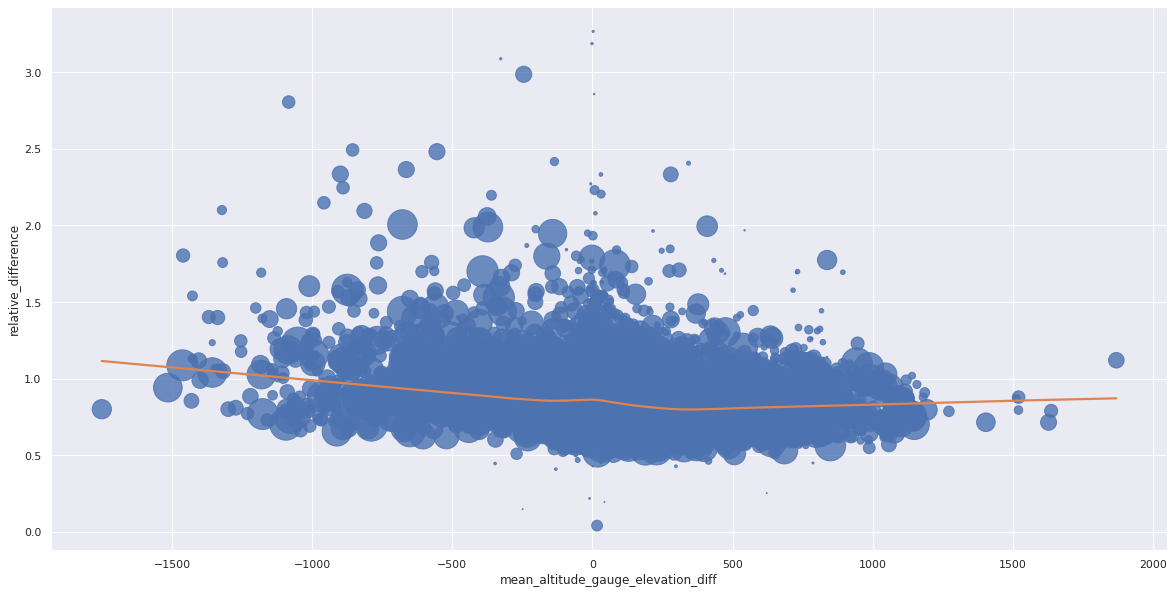

In [ ]:
sns.regplot(x='mean_altitude_gauge_elevation_diff', y='relative_difference', data=df_altitude_gauge_elev_diff_relative, scatter_kws={'s': df_altitude_gauge_elev_diff_relative['count']}, lowess = True, line_kws={"color": "C1"})


### absolute difference vs rain gauge altitude

In [ ]:
sql_query= """SELECT pgf.elevation , AVG(ABS(MEAN_TARGET - PRCP)) AS ABS_DIFFERENCE , COUNT(*) As count
FROM catchment_features cf
INNER JOIN precipitation_gauge_features pgf ON cf.HYBAS_ID = pgf.HYBAS_ID 
INNER JOIN precipitation_gauge_measurements pgm ON pgf.STATION = pgm.STATION 
INNER JOIN SECOND_TARGET t ON t.ZONE = pgf.HYBAS_ID AND YEAR(t.DATE_TARGET) = YEAR(pgm.MEASUREMENT_DATE) AND MONTH(t.DATE_TARGET) = MONTH(pgm.MEASUREMENT_DATE) AND DAY(t.DATE_TARGET) = DAY(pgm.MEASUREMENT_DATE)
WHERE t.mean_target > 5
GROUP BY pgf.elevation;"""

cursor = ctx.cursor()
cursor.execute(sql_query)
data = cursor.fetchall()
num_fields = len(cursor.description)
columns = [i[0].lower() for i in cursor.description]
df_elevation = pd.DataFrame(data, columns=columns)
cursor.close()
df_elevation = df_elevation.dropna(axis=0)

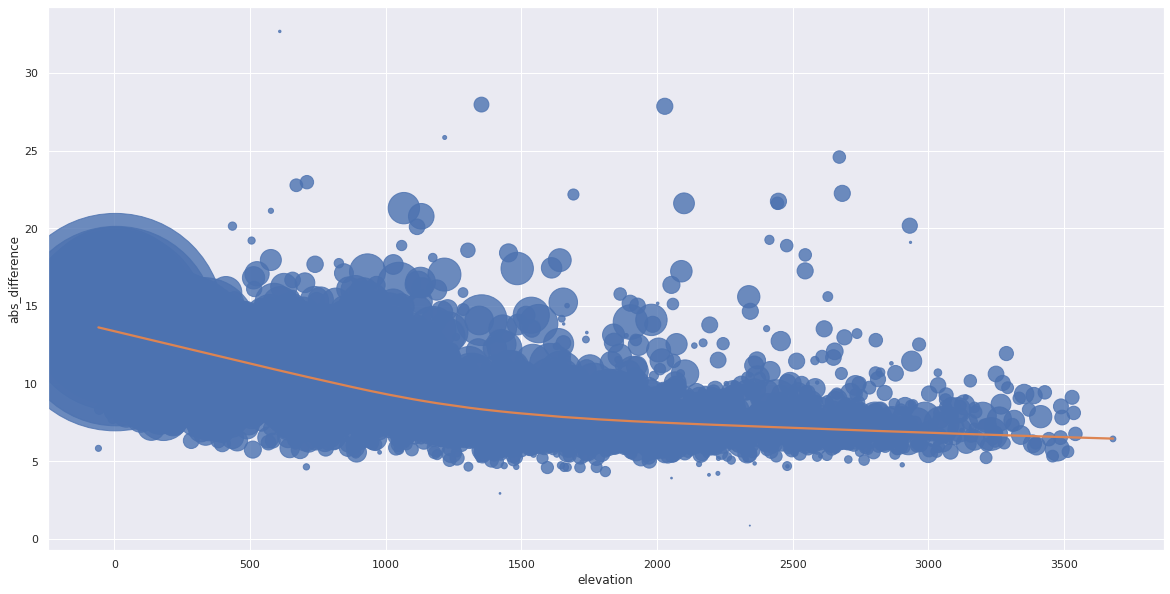

In [ ]:
sns.regplot(x='elevation', y='abs_difference', data=df_elevation, scatter_kws={'s': df_elevation['count']}, lowess = True, line_kws={"color": "C1"})


### relative absolute difference vs rain gauge elevation

In [ ]:
sql_query= """SELECT pgf.elevation , AVG(ABS(MEAN_TARGET - PRCP) / MEAN_TARGET) AS RELATIVE_DIFFERENCE , COUNT(*) As count
FROM catchment_features cf
INNER JOIN precipitation_gauge_features pgf ON cf.HYBAS_ID = pgf.HYBAS_ID 
INNER JOIN precipitation_gauge_measurements pgm ON pgf.STATION = pgm.STATION 
INNER JOIN SECOND_TARGET t ON t.ZONE = pgf.HYBAS_ID AND YEAR(t.DATE_TARGET) = YEAR(pgm.MEASUREMENT_DATE) AND MONTH(t.DATE_TARGET) = MONTH(pgm.MEASUREMENT_DATE) AND DAY(t.DATE_TARGET) = DAY(pgm.MEASUREMENT_DATE)
WHERE t.mean_target > 5
GROUP BY pgf.elevation;"""

cursor = ctx.cursor()
cursor.execute(sql_query)
data = cursor.fetchall()
num_fields = len(cursor.description)
columns = [i[0].lower() for i in cursor.description]
df_elevation_relative = pd.DataFrame(data, columns=columns)
cursor.close()
df_elevation_relative = df_elevation_relative.dropna(axis=0)

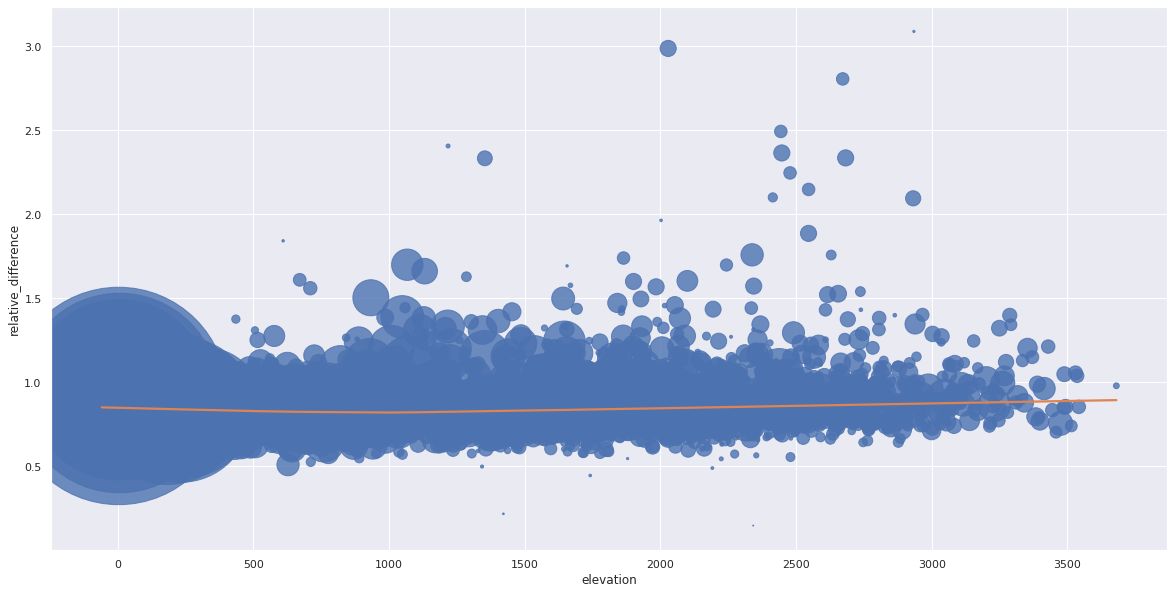

In [ ]:
sns.regplot(x='elevation', y='relative_difference', data=df_elevation_relative, scatter_kws={'s': df_elevation_relative['count']}, lowess = True, line_kws={"color": "C1"})


**again, the relative absolute difference doesn't show any linear relationship**

### relative absolute difference vs number of gauges

**it is it is plausible to assume that catchments that contain more rain gauges have a smaller mean difference than catchments that have less**

In [ ]:
sql_query= """SELECT MEASUREMENT_DATE, pgf.HYBAS_ID, NUM_GAUGES , AVG(MEAN_TARGET - PRCP) AS MEAN_DIFFERENCE 
FROM catchment_features cf
INNER JOIN precipitation_gauge_features pgf ON cf.HYBAS_ID = pgf.HYBAS_ID 
INNER JOIN precipitation_gauge_measurements pgm ON pgf.STATION = pgm.STATION 
INNER JOIN SECOND_TARGET t ON t.ZONE = pgf.HYBAS_ID AND YEAR(t.DATE_TARGET) = YEAR(pgm.MEASUREMENT_DATE) AND MONTH(t.DATE_TARGET) = MONTH(pgm.MEASUREMENT_DATE) AND DAY(t.DATE_TARGET) = DAY(pgm.MEASUREMENT_DATE)
WHERE t.mean_target > 5
GROUP BY MEASUREMENT_DATE, pgf.HYBAS_ID, NUM_GAUGES;"""

cursor = ctx.cursor()
cursor.execute(sql_query)
data = cursor.fetchall()
num_fields = len(cursor.description)
columns = [i[0].lower() for i in cursor.description]
df_num_gauges = pd.DataFrame(data, columns=columns)
cursor.close()

True

In [ ]:
df_num_gauges.head()

,measurement_date,hybas_id,num_gauges,mean_difference
0,2020-06-06,7070405210,16,7.550785
1,2020-09-18,7070405210,16,24.758171
2,2020-11-13,7070405210,16,27.085280
3,2020-12-13,7070405210,16,2.576362
4,2021-01-03,7070405210,16,20.437221


In [ ]:
grouped = df_num_gauges.groupby(['num_gauges'], as_index=False)['mean_difference'].agg('mean')


In [ ]:
grouped.head()

,num_gauges,mean_difference
0,1,4.990109
1,2,5.112655
2,3,4.788081
3,4,4.878358
4,5,4.725785


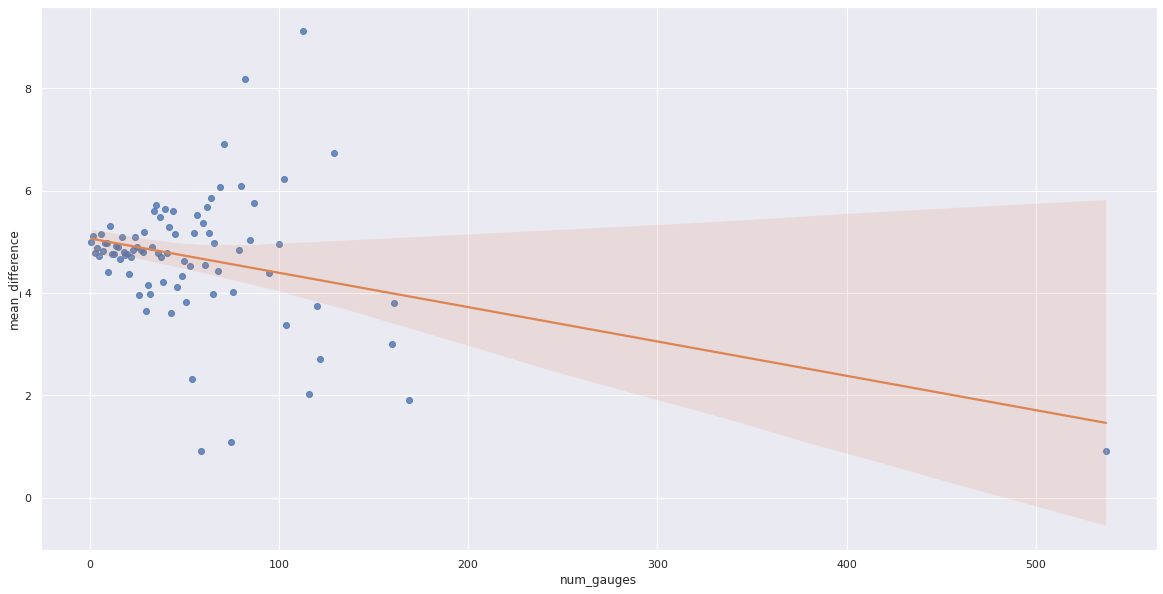

In [ ]:
sns.regplot(x='num_gauges', y='mean_difference', data=grouped, line_kws={"color": "C1"})


**the mean difference doesn't show any clear correlation with the number of gauges, but it still might be a relevant feature**

### relative absolute difference vs gauge distance to the center 

In [ ]:
sql_query= """SELECT SQUARE(POWER((centroid_latitude - pgf.latitude),2) + POWER((centroid_longitude - pgf.longitude),2)) AS DISTANCE_FROM_CENTROID, AVG(ABS(MEAN_TARGET - PRCP) / MEAN_TARGET) AS RELATIVE_DIFFERENCE , COUNT(*) As count
FROM catchment_features cf
INNER JOIN precipitation_gauge_features pgf ON cf.HYBAS_ID = pgf.HYBAS_ID 
INNER JOIN precipitation_gauge_measurements pgm ON pgf.STATION = pgm.STATION 
INNER JOIN SECOND_TARGET t ON t.ZONE = pgf.HYBAS_ID AND YEAR(t.DATE_TARGET) = YEAR(pgm.MEASUREMENT_DATE) AND MONTH(t.DATE_TARGET) = MONTH(pgm.MEASUREMENT_DATE) AND DAY(t.DATE_TARGET) = DAY(pgm.MEASUREMENT_DATE)
WHERE t.mean_target > 5
GROUP BY SQUARE(POWER((centroid_latitude - pgf.latitude),2) + POWER((centroid_longitude - pgf.longitude),2));"""

cursor = ctx.cursor()
cursor.execute(sql_query)
data = cursor.fetchall()
num_fields = len(cursor.description)
columns = [i[0].lower() for i in cursor.description]
df_dist_from_centroid = pd.DataFrame(data, columns=columns)
cursor.close()
df_dist_from_centroid = df_dist_from_centroid.dropna(axis=0)

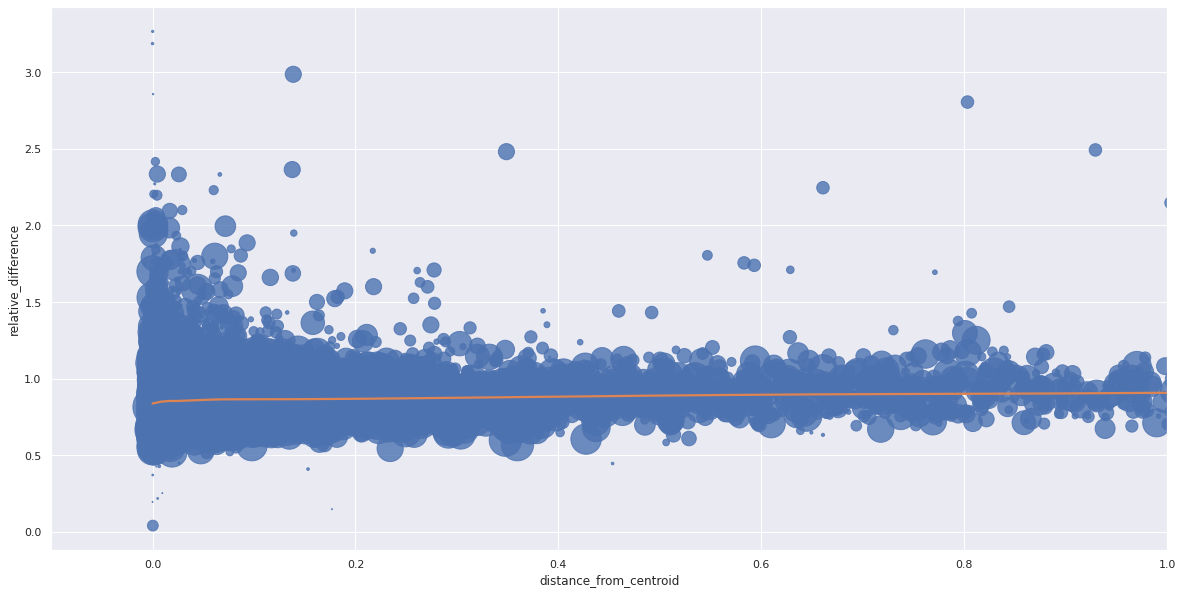

In [ ]:
plt.xlim(-0.1, 1)
sns.regplot(x='distance_from_centroid', y='relative_difference', data=df_dist_from_centroid, scatter_kws={'s': df_dist_from_centroid['count']}, lowess = True, line_kws={"color": "C1"})


**also the distance to the center of the catchment doesn't seem to be correlated to the relative difference**